In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d

from kan import *
from use_training_set import *
import use_KAN
# from use_KAN import *

from lmfit import Minimizer, Parameters, create_params, report_fit, Model


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


## load model

In [2]:
cpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = cpu

In [3]:
string_setting = "9-1_7_g_12_16_raw"
# string_setting = "9_7_g_12_16_cos_raw"  # uncomment to use cos model
fname_setup = f'setup_model_{string_setting}.txt'
with open(fname_setup, 'r') as file:
    config = yaml.safe_load(file)
config["device"] = device
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)
# model_KAN = use_KAN.build_model_cos(config['Model Setup'], device=device)  # uncomment to use cos model

f_Qx = lambda Q: np.vstack([Q,np.ones_like(Q)]).T
# f_Qx = lambda Q: np.vstack([np.cos(2*np.pi*Q/1),np.cos(2*np.pi*Q/2),np.cos(2*np.pi*Q/4),np.cos(2*np.pi*Q/8),np.cos(2*np.pi*Q/16), np.ones_like(Q)]).T  # uncomment to use cos model
use_KAN.update_Qx(f_Qx=f_Qx, config=config)

fname_BR = f"./saved_model/KAN/model_{string_setting}.pth"
model_KAN.load_state_dict(torch.load(fname_BR))

lf_IQ_KAN = lambda x, Q: use_KAN.f_IQ_KAN(model_KAN, x, Q, f_Qx=f_Qx, device=device)
# lf_IQ_KAN = lambda x, Q: use_KAN.f_IQ_KAN_cos(model_KAN, x, Q, f_Qx=f_Qx, device=device)  # uncomment to use cos model

Device set to: cuda:0
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Qx and Qx_inv have been defined and updated.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Model has been redefined.


In [4]:
model_KAN.kan

MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): Identity()
    )
  )
  (base_fun): Identity()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)

In [5]:
config

{'Model Setup': {'Q_scale': 0.16666666666666666,
  'base_fun': 'identity',
  'device': 'cuda',
  'grid': 12,
  'grid_aug': 16,
  'grid_eps': 1,
  'k': 3,
  'model_class': 'SQ_KAN',
  'multiplier': 4,
  'noise_scale': 1,
  'seed': 11451419,
  'width': [[4, 0], [9, 0], [1, 0], [1, 0]],
  'width_aug': [[3, 0], [7, 0], [3, 0]]},
 'Training Configuration': {},
 'device': device(type='cuda', index=0)}

In [6]:
config_file = 'setup_ts.txt'
x_train, y_train, Q_train = load_training_data(config_file, extend=True)
print(x_train.shape)
print(y_train.shape)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)
I_train = np.exp(y_train)

logk_z = x_train[:, 0]
k_z = np.exp(logk_z)
# logk_z = np.log(k_z)
alpha = x_train[:, 2]
logkappa = x_train[:, 1]
kappa = np.exp(logkappa)
# logkappa = np.log(kappa)
set_k_z = np.unique(logk_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique((logkappa)))


k_z in
[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   2.   3.   4.   5.
  6.   7.   8.   9.  10. ]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]
(4000, 3)
(4000, 126)


## load experimental data

In [7]:
def unpack_data(data):
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    # sigma_Q = data[:,3]
    return Q, IQ, IQ_er

In [8]:
## load experimental data
W_list = [30,40,50]
## load D22 data
n_des = 3
data_path = '../../Data/AOT-DesmearedData/'
data_list = []
for W in W_list:
    filename = '{}_des{}.txt'.format(W,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]

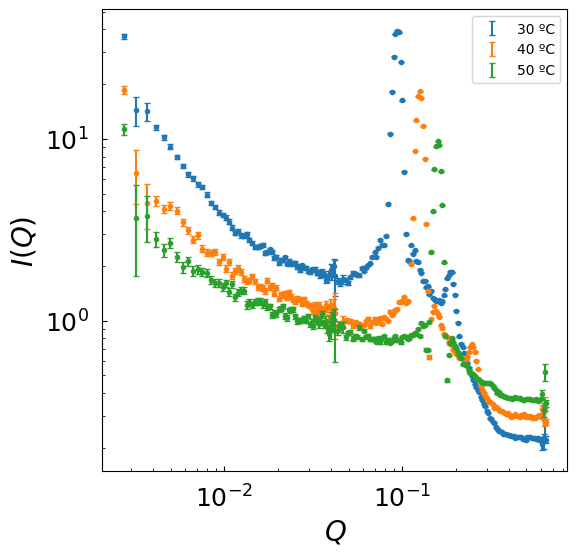

In [9]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    dataname = '{} ºC'.format(W)
    Q, IQ, IQ_er = unpack_data(data)
    ax.plot(Q,IQ,'.', color = colors[i_W])
    ax.errorbar(Q,IQ,IQ_er,linestyle='',label=dataname, color = colors[i_W] ,capsize=2)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend()

max_Q = 0.64574395
0.09388037
0.12554282
0.15828075


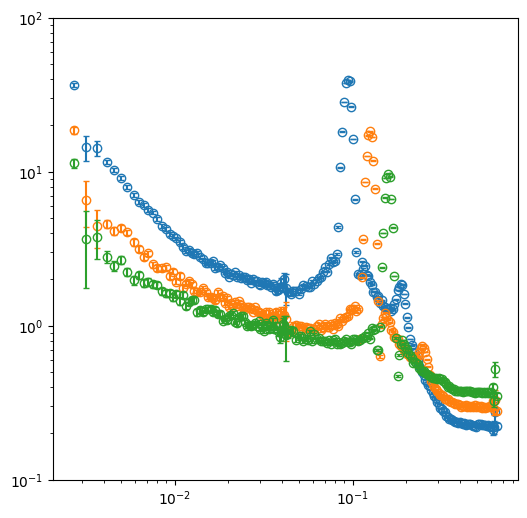

In [10]:
Q_list = []
IQ_list = []
IQ_er_list = []
Q_max_list = []
max_Q = Q[-1]
print('max_Q = {}'.format(max_Q))
delta_Q_list = []

box_size = 2
n_grid_scale = 256
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    Q, IQ, IQ_er = unpack_data(data)
    Q_list.append(Q)

    ## peak_position
    index_peak_range = Q>4e-2
    Q_peak_range = Q[index_peak_range]
    IQ_peak_range = IQ[index_peak_range]

    index_Q_max = np.argmax(IQ_peak_range)
    Q_max = Q_peak_range[index_Q_max]
    print(Q_max)
    Q_max_list.append(Q_max)

    IQ_list.append(IQ)
    IQ_er_list.append(IQ_er)

    ax.plot(Q, IQ, 'o', label=data[0], color=colors[i_W], fillstyle='none')
    ax.errorbar(Q, IQ, IQ_er,linestyle='',label=dataname, color = colors[i_W] ,capsize=2)

IQ_list = np.array(IQ_list)
IQ_er_list = np.array(IQ_er_list)

ax.set_ylim([1e-1,1e2])

ax.set_yscale('log')
ax.set_xscale('log')

In [11]:
from scipy.special import erf
def volume_fraction(alpha):
    '''
    Evaluate the fraction of water given clipping level alpha
    '''
    return 1-(1+erf(alpha/np.sqrt(2)))/2

## Fit the data

In [12]:
result_list = []

### 30%

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 579
    # data points      = 98
    # variables        = 6
    chi-square         = 136726.028
    reduced chi-square = 1486.15247
    Akaike info crit   = 721.595159
    Bayesian info crit = 737.104964
[[Variables]]
    sigma_k:  0.19225631 +/- 9.1555e-04 (0.48%) (init = 0.1945639)
    kappa:    7.73233444 +/- 0.01350612 (0.17%) (init = 7.759477)
    alpha:    0.70000049 +/- 8.9672e-06 (0.00%) (init = 0.7101702)
    y_scale:  1308832.31 +/- 50216.5033 (3.84%) (init = 1321635)
    x_scale:  1.01158843 +/- 0.00139129 (0.14%) (init = 1.000745)
    bg:       0.15000000 +/- 8.8950e-07 (0.00%) (init = 0.1499846)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, alpha)     = +0.6129
    C(alpha, x_scale)   = -0.6061
    C(kappa, x_scale)   = -0.4722
    C(sigma_k, x_scale) = -0.4433
    C(y_scale, bg)      = +0.4295
    C(sigma_k, y_scale) = +0.3096
    C(sigma_k, alpha)   = +0.3052
    C(y_scale, x

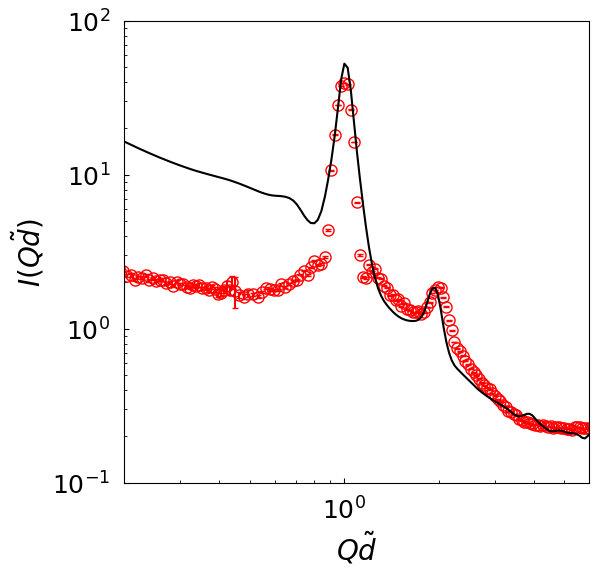

In [13]:
# fitting targets
index_data = 0
IQ_data = IQ_list[index_data]
IQ_er_data = IQ_er_list[index_data]
Q_max = Q_max_list[index_data]
index_Q = (Q/Q_max>0.8)*(Q/Q_max<6)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.2, min=0.1, max=0.3)
params.add('kappa', value=6.2, min=5.5, max=8)
params.add('alpha', value=0.8, min=0.7, max=1)
params.add('y_scale', value=8.5e5, min=1e5, max=2e6)
params.add('x_scale', value=1, min=0.95, max=1.05, vary=True)
params.add('bg', value=0.11, min=0.1, max=0.15, vary=True)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    x = np.array([np.log(v['sigma_k']),np.log(v['kappa']),v['alpha']])
    x_torch = use_KAN.to_torch_device(x, device=device)
    log_IQ_KAN = lf_IQ_KAN(x_torch, Q/v['x_scale'])
    IQ_scaled = np.exp(log_IQ_KAN.cpu().detach().numpy())[0]
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
result = minner.minimize('nelder')
# result = minner.minimize('emcee')
minner = Minimizer(lmbda, result.params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
result = minner.minimize('powell')
# result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))

# fitting targets
index_data = 0
Q_max = Q_max_list[index_data]
# result = result_list[index_data]

IQ_KAN = IQ_th(result.params, Q/Q_max)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(Q/Q_max,IQ_data,'or',fillstyle='none',ms=8)
ax.errorbar(Q/Q_max,IQ_data,IQ_er_data,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(Q/Q_max,IQ_KAN,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,6])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)


### 40%

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 706
    # data points      = 94
    # variables        = 6
    chi-square         = 40654.2693
    reduced chi-square = 461.980333
    Akaike info crit   = 582.539049
    Bayesian info crit = 597.798818
[[Variables]]
    sigma_k:  0.10508069 +/- 3.8761e-04 (0.37%) (init = 0.2)
    kappa:    5.25355813 +/- 0.00525638 (0.10%) (init = 5.2)
    alpha:    0.69203457 +/- 0.00463257 (0.67%) (init = 0.7)
    y_scale:  499649.565 +/- 15802.3801 (3.16%) (init = 500000)
    x_scale:  1.01645064 +/- 0.00107102 (0.11%) (init = 1)
    bg:       0.27108455 +/- 0.00375062 (1.38%) (init = 0.25)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma_k, alpha)   = -0.6618
    C(alpha, y_scale)   = -0.5611
    C(sigma_k, y_scale) = +0.5446
    C(sigma_k, kappa)   = +0.5439
    C(kappa, alpha)     = -0.5117
    C(alpha, x_scale)   = +0.4230
    C(kappa, y_scale)   = +0.3930
    C(sigma_k, x_scale) = -0.3493
    C(kappa,

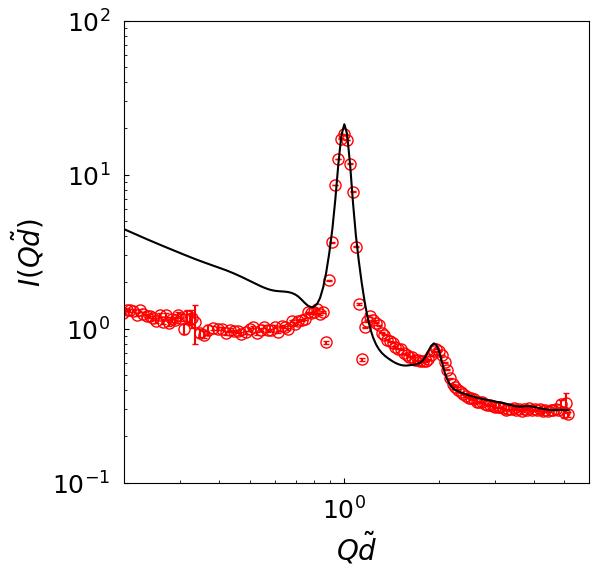

In [14]:
# fitting targets
index_data = 1
IQ_data = IQ_list[index_data]
IQ_er_data = IQ_er_list[index_data]
Q_max = Q_max_list[index_data]
index_Q = (Q/Q_max>0.8)*(Q/Q_max<6)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.2, min=0.1, max=0.3)
params.add('kappa', value=5.2, min=5, max=6)
params.add('alpha', value=0.7, min=0.3, max=1.0)
params.add('y_scale', value=5e5, min=1e5, max=1e6)
params.add('x_scale', value=1.0, min=0.9, max=1.1, vary=True)
params.add('bg', value=0.25, min=0.1, max=0.3)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    x = np.array([np.log(v['sigma_k']),np.log(v['kappa']),v['alpha']])
    x_torch = use_KAN.to_torch_device(x, device=device)
    log_IQ_KAN = lf_IQ_KAN(x_torch, Q/v['x_scale'])
    IQ_scaled = np.exp(log_IQ_KAN.cpu().detach().numpy())[0]
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
# minner = Minimizer(lmbda, params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
# result = minner.minimize('nelder')
# result = minner.minimize('emcee')
minner = Minimizer(lmbda, params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
result = minner.minimize('powell')

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))

# fitting targets
Q_max = Q_max_list[index_data]
# result = result_list[index_data]

IQ_KAN = IQ_th(result.params, Q/Q_max)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(Q/Q_max,IQ_data,'or',fillstyle='none',ms=8)
ax.errorbar(Q/Q_max,IQ_data,IQ_er_data,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(Q/Q_max,IQ_KAN,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,6])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)


### 50%

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 428
    # data points      = 83
    # variables        = 6
    chi-square         = 16113.3803
    reduced chi-square = 209.264679
    Akaike info crit   = 449.290868
    Bayesian info crit = 463.803912
[[Variables]]
    sigma_k:  0.29664711 +/- 4.8645e-04 (0.16%) (init = 0.41)
    kappa:    1.20552340 +/- 0.00593471 (0.49%) (init = 1.2)
    alpha:    0.38854003 +/- 0.00272346 (0.70%) (init = 0.41)
    y_scale:  243310.370 +/- 11488.0703 (4.72%) (init = 240000)
    x_scale:  1.01863034 +/- 9.5151e-04 (0.09%) (init = 1.025)
    bg:       0.35178032 +/- 0.00609123 (1.73%) (init = 0.33)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma_k, y_scale) = -0.9039
    C(y_scale, bg)      = -0.5839
    C(sigma_k, bg)      = +0.4929
    C(sigma_k, alpha)   = +0.3205
    C(kappa, alpha)     = -0.2465
    C(alpha, x_scale)   = -0.2048
    C(alpha, y_scale)   = -0.2037
volume_fraction = 0.3488082172674225


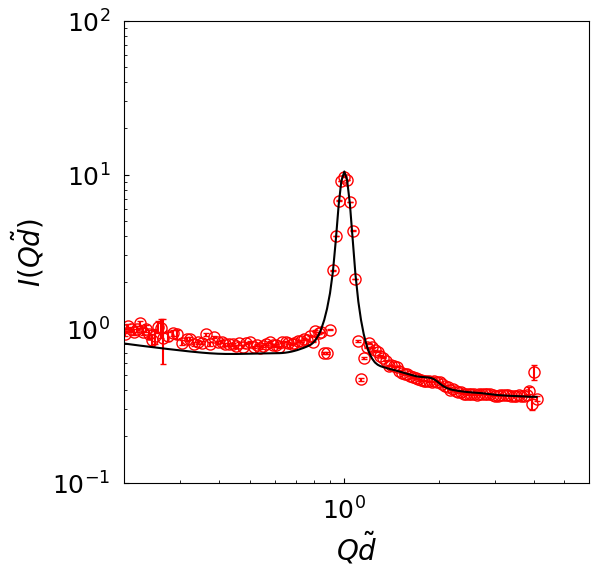

In [15]:
# fitting targets
index_data = 2
IQ_data = IQ_list[index_data]
IQ_er_data = IQ_er_list[index_data]
Q_max = Q_max_list[index_data]
index_Q = (Q/Q_max>0.8)*(Q/Q_max<5)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.41, min=0.05, max=1.0)
params.add('kappa', value=1.2, min=1, max=2)
params.add('alpha', value=0.41, min=0.0, max=0.45)
params.add('y_scale', value=2.4e5, min=2e5, max=1e6)
params.add('x_scale', value=1.025, min=0.9, max=1.2, vary=True)
params.add('bg', value=0.33, min=0.25, max=0.45)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    x = np.array([np.log(v['sigma_k']),np.log(v['kappa']),v['alpha']])
    x_torch = use_KAN.to_torch_device(x, device=device)
    log_IQ_KAN = lf_IQ_KAN(x_torch, Q/v['x_scale'])
    IQ_scaled = np.exp(log_IQ_KAN.cpu().detach().numpy())[0]
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
# result = minner.minimize('emcee')
result = minner.minimize('powell')
# result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))

# fitting targets
Q_max = Q_max_list[index_data]
# result = result_list[index_data]

IQ_KAN = IQ_th(result.params, Q/Q_max)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(Q/Q_max,IQ_data,'or',fillstyle='none',ms=8)
ax.errorbar(Q/Q_max,IQ_data,IQ_er_data,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(Q/Q_max,IQ_KAN,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,6])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)


In [16]:
"""
SOLARIZED HEX     16/8 TERMCOL  XTERM/HEX   L*A*B      RGB         HSB
--------- ------- ---- -------  ----------- ---------- ----------- -----------
base03    #002b36  8/4 brblack  234 #1c1c1c 15 -12 -12   0  43  54 193 100  21
base02    #073642  0/4 black    235 #262626 20 -12 -12   7  54  66 192  90  26
base01    #586e75 10/7 brgreen  240 #585858 45 -07 -07  88 110 117 194  25  46
base00    #657b83 11/7 bryellow 241 #626262 50 -07 -07 101 123 131 195  23  51
base0     #839496 12/6 brblue   244 #808080 60 -06 -03 131 148 150 186  13  59
base1     #93a1a1 14/4 brcyan   245 #8a8a8a 65 -05 -02 147 161 161 180   9  63
base2     #eee8d5  7/7 white    254 #e4e4e4 92 -00  10 238 232 213  44  11  93
base3     #fdf6e3 15/7 brwhite  230 #ffffd7 97  00  10 253 246 227  44  10  99
yellow    #b58900  3/3 yellow   136 #af8700 60  10  65 181 137   0  45 100  71
orange    #cb4b16  9/3 brred    166 #d75f00 50  50  55 203  75  22  18  89  80
red       #dc322f  1/1 red      160 #d70000 50  65  45 220  50  47   1  79  86
magenta   #d33682  5/5 magenta  125 #af005f 50  65 -05 211  54 130 331  74  83
violet    #6c71c4 13/5 brmagenta 61 #5f5faf 50  15 -45 108 113 196 237  45  77
blue      #268bd2  4/4 blue      33 #0087ff 55 -10 -45  38 139 210 205  82  82
cyan      #2aa198  6/6 cyan      37 #00afaf 60 -35 -05  42 161 152 175  74  63
green     #859900  2/2 green     64 #5f8700 60 -20  65 133 153   0  68 100  60
"""
solarized_base03 = "#002b36"
solarized_base02 = "#073642"
solarized_base01 = "#586e75"
solarized_base00 = "#657b83"
solarized_base0 = "#839496"
solarized_base1 = "#93a1a1"
solarized_base2 = "#eee8d5"
solarized_base3 = "#fdf6e3"
solarized_yellow = "#b58900"
solarized_orange = "#cb4b16"
solarized_red = "#dc322f"
solarized_magenta = "#d33682"
solarized_violet = "#6c71c4"
solarized_blue = "#268bd2"
solarized_cyan = "#2aa198"
solarized_green = "#859900"

color_list = [solarized_red, solarized_blue, solarized_cyan, solarized_violet]

/tmp/ipykernel_373326/1686441766.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(qq_plot[index_Q],IQ_data[index_Q]*10**(index_data*2),


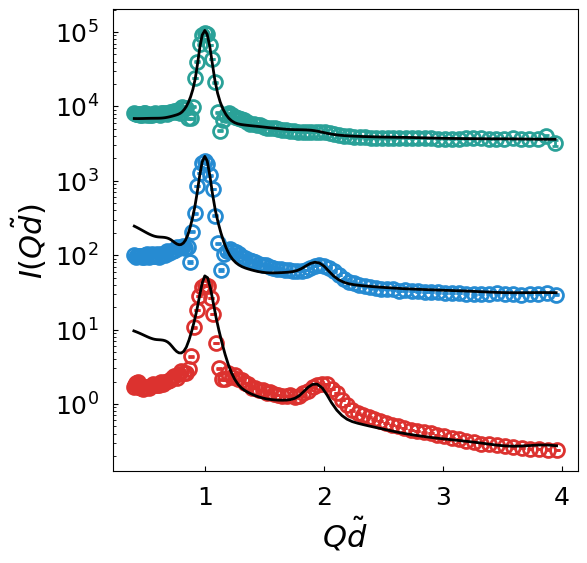

In [17]:
# color_list = ['C0','C1','C2','C3','C4']
# color_list = ['#e7298a','#1b9e77','#d95f02','#984ea3','#ffffb3']
# color_list = [c for c in plt.cm.plasma(np.linspace(0,0.8,3))]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for index_data in range(3):
    IQ_data = IQ_list[index_data,:]
    IQ_er_data = IQ_er_list[index_data,:]
    result = result_list[index_data]
    Q_max = Q_max_list[index_data]
    
    index_Q = (Q/Q_max>0.4)*(Q/Q_max<4)

    ## plot fitting results
    qq_plot = Q/Q_max
    ax.plot(qq_plot[index_Q],IQ_data[index_Q]*10**(index_data*2),
            'or',fillstyle='none',ms=10, color = color_list[index_data], markeredgewidth=2, lw=2)
    ax.errorbar(qq_plot[index_Q],IQ_data[index_Q]*10**(index_data*2),IQ_er_data[index_Q]*10**(index_data*2),
                linestyle='',label=dataname, color = color_list[index_data] ,capsize=2, markeredgewidth=2, lw=2,ms=10)
    # ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
    ax.plot(qq_plot[index_Q],
            IQ_th(result.params,qq_plot)[index_Q]*10**(index_data*2),'k-', markeredgewidth=2, lw=2)

    ax.set_xlabel(r'$Q\tilde{d}$',fontsize=22)
    ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=22)
    ax.set_yscale('log')
    # ax.set_xscale('log')
#     ax.set_xlim([0,4])
    # ax.set_ylim([0.1,100])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

